## Current it is still an autoencoder, next try with the ENCODER only

In [2]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 6.0, 4.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot

import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Concatenate, Dense, Activation, Reshape, Conv1D , Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization, Embedding, LSTM, Conv2DTranspose, UpSampling2D

Using TensorFlow backend.


CPU times: user 3.02 s, sys: 805 ms, total: 3.83 s
Wall time: 5.04 s


In [10]:
classes = 7
group = 5
training_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2

def reader_pmtall(path):
    extra = np.arange(4096, 4480)
    
    tree = uproot.open(path)["tree"]
    pmtall = tree.array("PMTALL")
    pmtall = np.delete(pmtall, extra, axis=1)
    return pmtall

def reader(path,branch,number):
    tree = uproot.open(path)["tree"]
    column = tree.array(branch)
    column = column[:,number]
    return column

def reader_lone(path,branch):
    tree = uproot.open(path)["tree"]
    column = tree.array(branch)
    return column

def pmtall_pedestal(path):
    pedestal = reader(path,"Pedestal",0)
    pmtall = reader_pmtall(path)
    for i in range(len(pedestal)):
        pmtall[i] = -(pmtall[i]-pedestal[i])
    
    return pmtall

def label(q,k):
    x = np.zeros(len(q))
    for i in range(len(q)):
        x[i] = k
    return x

def sep(q,k,z):
    y = label(q,k)
    x1, x2 ,x3 = np.split(q,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    y1, y2 ,y3 = np.split(y,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    if z == 0:
        return x1, y1
    if z == 1:
        return x2, y2
    if z == 2:
        return x3, y3
    
def comb(one,two,three,four,five,portion):
    one1,one2 = sep(one,0,portion)
    two1,two2 = sep(two,1,portion)
    three1,three2 = sep(three,2,portion)
    four1,four2 = sep(four,3,portion)
    five1,five2 = sep(five,4,portion)
#     six1,six2 = sep(six,5,portion)
#     seven1,seven2 = sep(seven,6,portion)
    
    z = np.concatenate((one1,two1,three1,four1,five1),axis=0)
    y = np.concatenate((one2,two2,three2,four2,five2),axis=0)
    return z, y

def comb5(one,two,three,four,five,portion):
    one1,one2 = sep(one,0,portion)    
    two1,two2 = sep(two,1,portion)
    three1,three2 = sep(three,2,portion)
    four1,four2 = sep(four,3,portion)
    five1,five2 = sep(five,4,portion)
    
    z = np.concatenate((one1,two1,three1,four1,five1),axis=0)
    y = np.concatenate((one2,two2,three2,four2,five2),axis=0)
    return z, y

def parameters(path):
    ratio4us = reader_lone(path,"Ratio4us")
    energy = reader(path,"Energy",1)
#     dataquality0 = reader(path,"DataQuality",0)
#     dataquality1 = reader(path,"DataQuality",1)
#     dataquality2 = reader(path,"DataQuality",2)
#     dataquality3 = reader(path,"DataQuality",3)
    psdpara1 = reader(path,"PSDPara",1)
    psdpara7 = reader(path,"PSDPara",7)
    psdpara13 = reader(path,"PSDPara",13)
    psdpara22 = reader(path,"PSDPara",22)
#     triggercounter33 = reader(path,"TriggerCounter",33)
#     triggercounter36 = reader(path,"TriggerCounter",36)
    crystaln = reader(path,"CrystalN",0)
    position = reader(path,"Position_wm",1)
    ratio = reader_lone(path,"Ratio")
    timingdiff = reader_lone(path,"TimingDiff")
    x = np.stack((ratio4us,energy,psdpara1,psdpara7,psdpara13,psdpara22,crystaln,position,ratio,timingdiff),axis=-1)
    return x

def generator(x):
    while 1:
        alpha = pmtall_pedestal("Alpha.root")
#         bad1 = pmtall_pedestal("BAD_DATA_QUALITY_1.root")
#         bad2 = pmtall_pedestal("BAD_DATA_QUALITY_2.root")
        piled = pmtall_pedestal("Piled_2.root")
        ls = pmtall_pedestal("LS.root")
        lsbeta = pmtall_pedestal("lsbeta.root")
        ref = pmtall_pedestal("RefPulse009.root")
        
        z1, z2 = comb(piled,ref,alpha,ls,lsbeta,x)
        s = np.random.permutation(np.arange(len(z2)))
        z1 = z1[s]
        z2 = z2[s]

        para_piled = parameters("Piled_2.root")
        para_ref = parameters("RefPulse009.root")
        para_alpha = parameters("Alpha.root")
        para_ls = parameters("LS.root")
        para_lsbeta = parameters("lsbeta.root")
        
        z3, z4 = comb5(para_piled,para_ref,para_alpha,para_ls,para_lsbeta,x)        
        z3 = z3[s] 
        z4 = z4[s]

        gasf = GASF(image_size=128, overlapping=False, scale='-1')
        
        for i in range(len(z2)):
            d1 = np.expand_dims(z1[i],axis=0)
            p = gasf.transform(d1)
            p2 = np.expand_dims(p,axis=3)
            q = keras.utils.to_categorical(z2[i],classes)
            r = normalize(d1,norm="l1")
            s = np.expand_dims(z3[i],axis=0)
            yield p,p2

test = generator(1)
# print(next(test)[0][0])
print(next(test)[0][0].shape)
print(next(test)[1][0].shape)
# print(next(test)[0][2].shape)
# print(next(test)[1].shape)

(128, 128)
(128, 128, 1)


# Autoencoder

In [3]:
feed_2d = Input(shape=(128,128))
model_en = Reshape((128,128,1),input_shape=(128,128))(feed_2d)
model_en = Conv2D(2, kernel_size=1)(model_en)
model_en = MaxPooling2D(pool_size=4)(model_en)
model_en = Activation("sigmoid")(model_en)
# model_en = Conv2D(4, kernel_size=1)(model_en)
# model_en = MaxPooling2D(pool_size=2)(model_en)
# model_en = Activation("relu")(model_en)
# model_en = Conv2D(8, kernel_size=1)(model_en)
# model_en = MaxPooling2D(pool_size=2)(model_en)
# model_en = Activation("relu")(model_en)
model_en = Flatten()(model_en)
# model_en = Dense(256,activation="relu")(model_en)
# model_en = Dropout(0.2)(model_en)
model_en = Dense(128,activation="sigmoid")(model_en)
model_en = Dropout(0.2)(model_en)
model_en = Dense(64,activation="sigmoid")(model_en)
model_en = Dropout(0.2)(model_en)

model_de = Dense(128,activation="sigmoid")(model_en)
model_de = Dropout(0.2)(model_de)
# model_de = Dense(256,activation="relu")(model_de)
# model_de = Dropout(0.2)(model_de)
# model_de = Reshape((256,1),input_shape=(256,))(model_de)
# model_de = UpSampling1D(16)(model_de)
# model_de = Dense(4,activation="relu")(model_de)
# model_de = UpSampling1D(4)(model_de)
# model_de = Dense(4,activation="relu")(model_de)

model_de = Dense(4096,activation="sigmoid")(model_de)
model_de = Dropout(0.2)(model_de)
model_de = Reshape((32,32,4),input_shape=(4096,))(model_de)
model_de = UpSampling2D(size=(2, 2))(model_de)
model_de = Conv2DTranspose(4,1)(model_de)
model_de = UpSampling2D(size=(2, 2))(model_de)
model_de = Conv2DTranspose(2,1)(model_de)
# model_de = UpSampling2D(size=(2, 2))(model_de)
model_de = Conv2DTranspose(1,1)(model_de)

autoencoder = Model(feed_2d,model_de)
autoencoder.summary()
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


# mult = multiple_inputs()
# mult.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 2)       4         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 2)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 2)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
__________

# Encoder

In [13]:
feed_2d = Input(shape=(128,128))
model = Reshape((128,128,1),input_shape=(128,128))(feed_2d)
model = Conv2D(128, kernel_size=1)(model)
model = MaxPooling2D(pool_size=4)(model)
model = Activation("relu")(model)
# model_en = Conv2D(4, kernel_size=1)(model_en)
# model_en = MaxPooling2D(pool_size=2)(model_en)
# model_en = Activation("relu")(model_en)
# model_en = Conv2D(8, kernel_size=1)(model_en)
# model_en = MaxPooling2D(pool_size=2)(model_en)
# model_en = Activation("relu")(model_en)
# model = Flatten()(model)
# model = Dense(256,activation="relu")(model)
# model_en = Dropout(0.2)(model_en)
# model = Dense(128,activation="sigmoid")(model)
# model = Dropout(0.2)(model)
# model = Dense(64,activation="sigmoid")(model)
# model = Dropout(0.2)(model)

# model = Dense(128,activation="sigmoid")(model)
# model = Dropout(0.2)(model)
# model_de = Dense(256,activation="relu")(model_de)
# model_de = Dropout(0.2)(model_de)
# model_de = Reshape((256,1),input_shape=(256,))(model_de)
# model_de = UpSampling1D(16)(model_de)
# model_de = Dense(4,activation="relu")(model_de)
# model_de = UpSampling1D(4)(model_de)
# model_de = Dense(4,activation="relu")(model_de)

# model = Dense(4096,activation="sigmoid")(model)
# model = Dropout(0.2)(model)
# model = Reshape((32,32,4),input_shape=(4096,))(model)
model = UpSampling2D(size=(2, 2))(model)
model = Conv2DTranspose(64,1)(model)
model = UpSampling2D(size=(2, 2))(model)
model = Conv2DTranspose(1,1)(model)
# # model_de = UpSampling2D(size=(2, 2))(model_de)
# model = Conv2DTranspose(1,1)(model)

autoencoder = Model(feed_2d,model)
autoencoder.summary()
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 128, 128)          0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 128)     256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
up_sampling2d_13 (UpSampling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 64, 64, 64)        8256      
__________

Epoch 1/2
21430/21430 [==============================] - 776s - loss: -0.5402 - val_loss: -0.5563
Epoch 2/2
21430/21430 [==============================] - 677s - loss: -0.5421 - val_loss: -0.5554
dict_keys(['loss', 'val_loss'])


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


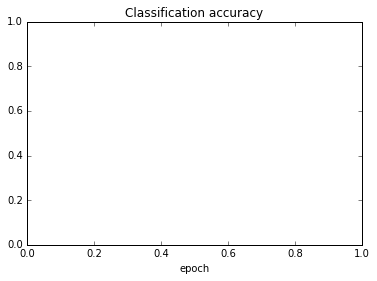

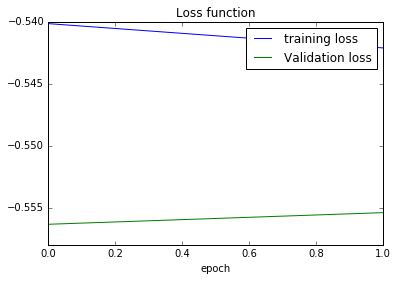

In [14]:
train_gen = generator(0)
val_gen = generator(1)
test_gen = generator(2)

steps_t = 21430
steps_vt = 3062

# from keras.models import load_model

# mult = load_model("combined_3_network.h5")

history = autoencoder.fit_generator(train_gen,steps_per_epoch=steps_t, epochs=2, verbose=1, validation_data=val_gen,validation_steps=steps_vt)
print(history.history.keys())
plt.figure()
plt.title("Classification accuracy")
plt.xlabel("epoch")
# plt.plot(history.history['acc'],label="training accuracy")
# plt.plot(history.history['val_acc'],label="Validation accuracy")
plt.legend(loc=4)
plt.show()

plt.figure()
plt.title("Loss function")
plt.xlabel("epoch")
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.legend()
plt.show()

# print("Classification accuracy =",history.history['val_acc'][-1])

# mult.save("3network_random_label.h5")

# score = autoencoder.evaluate_generator(test_gen,steps=1531)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])





(1, 128, 128)
(128, 128)
(128, 128)


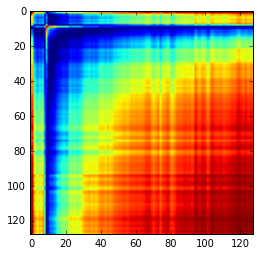

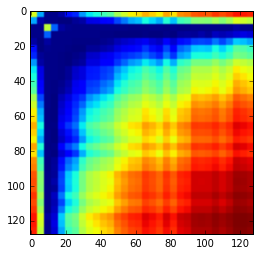

In [32]:
test_img = next(test_gen)[0]

print(test_img.shape)

reconstructed = autoencoder.predict(test_img)
reconstructed = np.squeeze(reconstructed)
print(reconstructed.shape)

test_img_plt = np.squeeze(test_img)
print(test_img_plt.shape)

plt.figure()
plt.imshow(test_img_plt)
plt.show()

plt.figure()
plt.imshow(reconstructed)
plt.show()